In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from functools import cmp_to_key

In [4]:
def list_str2float(x):
    return list(map(float, x.replace('[','').replace(']','').split(',')))

def accepted_h0(pvals, alpha):
    return np.mean(np.array(list_str2float(pvals)) > alpha)

In [5]:
def compare(item1, item2):
    if item1.startswith('N0'):
        if item2.startswith('N0'):
            if item1 < item2:
                return -1
            if item1 > item2:
                return 1
            return 0
        else:
            return -1
    elif item2.startswith('N0'):
        return 1
    else:
        if item1 < item2:
            return -1
        if item1 > item2:
            return 1
        return 0
    
def sort_distrib_names(l):
    return sorted(l, key=cmp_to_key(compare))

## Power as heat maps

In [10]:
def get_tt_power(df, true_distrib, alter_distrib, alpha):
    # find critial value of KS statistic
    df_filtred = df[(df['true_dist'] == true_distrib) & (df['alter_dist'] == alter_distrib)]
    try:
        return 1 - accepted_h0(df_filtred.pvals.values[0], alpha)
    except:
        return np.nan

def plot_power_matrix_tt(df, label, alpha=0.05, output_to_file=True):
    dists = df.alter_dist.unique().tolist()
    #dists = sort_distrib_names(dists)
    print(dists)
    try:
        # there is sth broken with n=2500 dim=5
        dists.remove('N01xN01xT5xT5xT5')
    except:
        pass
    n_dist = len(dists)
    values = np.zeros((n_dist, n_dist))
    avg_power = []
    signif = []
    for id_td, td in enumerate(dists):
        for id_ad, ad in enumerate(dists):
            values[id_td, id_ad] = get_tt_power(df, td, ad, alpha)
            if td != ad:
                avg_power.append(values[id_td, id_ad])
            else:
                signif.append(values[id_td, id_ad])
    #print(values)
    avg_power = np.nanmean(avg_power)
    initial_fig_size = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.imshow(values)
    # add value in each cell
    for id_td, td in enumerate(dists):
        for id_ad, ad in enumerate(dists):
            val = values[id_ad, id_td] #this is correct, opposite x<->y
            if val<0.4:
                color='white'
            else:
                color='black'
            plt.text(id_td-0.33, id_ad, f'{val:.2f}', color=color, fontsize=9, fontweight='bold',
                    horizontalalignment='left')
    plt.xticks(ticks=range(len(dists)), labels=dists, rotation=90, fontsize=13)
    plt.yticks(range(len(dists)), labels=dists, fontsize=13)
    plt.xlabel('ALTERNATIVE Distribution', fontsize=14)
    plt.ylabel('TRUE Distribution', fontsize=14)
    plt.title(f'{label} \n Average Power: {avg_power:.4f}', fontsize=15)
    c = plt.colorbar()
    plt.clim(0, 1)
    if output_to_file:
        plt.savefig(f'plots/1sample_{label.replace(" ", "_")}.pdf', bbox_inches='tight')
    else:
        plt.show()
    plt.rcParams['figure.figsize'] = initial_fig_size
    plt.clf()

In [11]:
def get_ks_power(df, true_distrib, alter_distrib, alpha):
    # find critial value of KS statistic
    try:
        df_filtred = df[(df['true_dist'] == true_distrib) & (df['alter_dist'] == true_distrib)]
        D = np.quantile(list_str2float(df_filtred.dks.values[0]), 1-alpha)
        df_filtred = df[(df['true_dist'] == true_distrib) & (df['alter_dist'] == alter_distrib)]
        val = 1 - np.mean(list_str2float(df_filtred.dks.values[0]) < D)
    except:
        val = np.nan
    return val

def plot_power_matrix_ks(df, label, alpha=0.05, output_to_file=True):
    dists = df.alter_dist.unique()
    #dists = sort_distrib_names(dists)
    try:
        # there is sth broken with n=2500 dim=5
        dists.remove('N01xN01xT5xT5xT5')
    except:
        pass
    n_dist = len(dists)
    values = np.zeros((n_dist, n_dist))
    avg_power = []
    signif = []
    for id_td, td in enumerate(dists):
        for id_ad, ad in enumerate(dists):
            values[id_td, id_ad] = get_ks_power(df, td, ad, alpha)
            if td != ad:
                avg_power.append(values[id_td, id_ad])
            else:
                signif.append(values[id_td, id_ad])
    #print(values)
    avg_power = np.nanmean(avg_power)
    #initial_fig_size = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.imshow(values)
    for id_td, td in enumerate(dists):
        for id_ad, ad in enumerate(dists):
            val = values[id_ad, id_td] #this is correct, opposite x<->y
            if val<0.4:
                color='white'
            else:
                color='black'
            plt.text(id_td-0.33, id_ad, f'{val:.2f}', color=color, fontsize=9, fontweight='bold',
                    horizontalalignment='left')

    plt.xticks(ticks=range(len(dists)), labels=dists, rotation=90, fontsize=13)
    plt.yticks(range(len(dists)), labels=dists, fontsize=13)
    plt.xlabel('ALTERNATIVE Distribution', fontsize=14)
    plt.ylabel('TRUE Distribution', fontsize=14)
    plt.title(f'{label} \n Average Power: {avg_power:.4f}', fontsize=15)
    c = plt.colorbar()
    plt.clim(0, 1)
    if output_to_file:
        plt.savefig(f'plots/1sample_{label.replace(" ", "_")}.pdf', bbox_inches='tight')
    else:
        plt.show()
    #plt.rcParams['figure.figsize'] = initial_fig_size
    plt.clf()    

In [12]:
def read_df_with_merge(filename):
    df = pd.read_csv(filename)
    # check if .continualtion file exists
    filename_cont = f'{filename}.cont'
    if os.path.isfile(filename_cont):
        print(f'Continuation file found: {filename_cont}')
        df_cont = pd.read_csv(filename_cont)
        df = pd.concat([df, df_cont], axis=0)
    return df

['N01xN01', 'MultiGauss0.1', 'MultiGauss0.5', 'MultiGauss0.9', 'T3xT3', 'T5xT5', 'T10xT10', 'LogisticxLogistic', 'LaplacexLaplace', 'N01xT5', 'GM_1xGM_1', 'N01xGM_1']


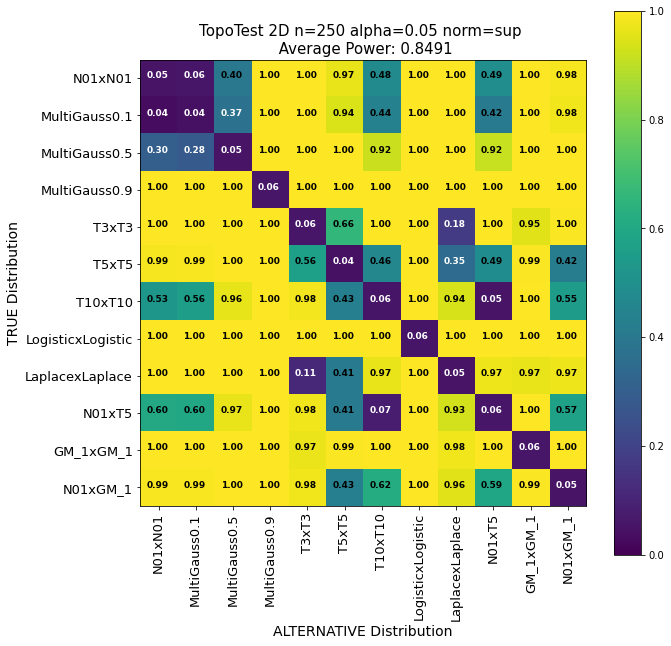

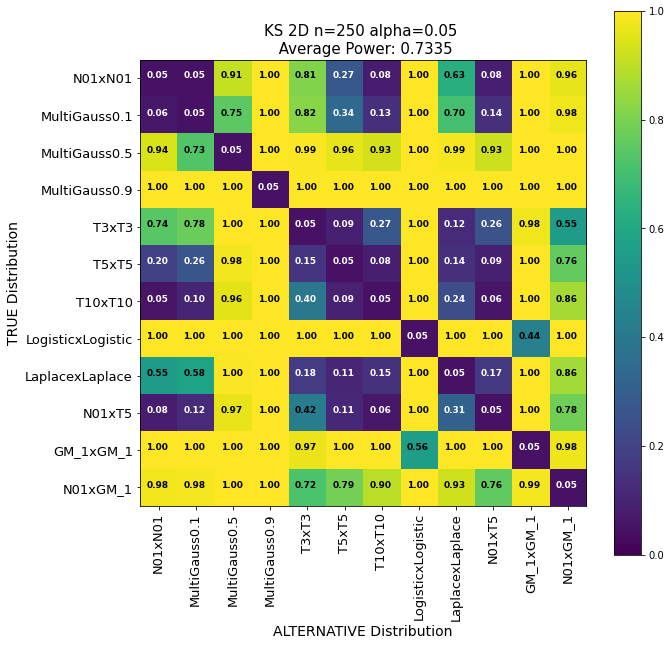

<Figure size 720x720 with 0 Axes>

In [45]:
# make one plot to see how it works
dim=2
n=250
alpha=0.05
norm='sup'
df_tt = read_df_with_merge(f'../results/dim={dim}_n={n}_norm={norm}_method=approximate.csv')
plot_power_matrix_tt(df_tt, label=f'TopoTest {dim}D n={n} alpha={alpha} norm={norm}', alpha=alpha,
                    output_to_file=False)

df_ks = read_df_with_merge(f'../results/ks_dim={dim}_n={n}.csv')
plot_power_matrix_ks(df_ks, label=f'KS {dim}D n={n} alpha={alpha}', alpha=alpha,
                    output_to_file=False)

In [13]:
dims = [1, 2, 3, 4, 5, 7]
ns=[100, 250, 500, 1000, 2500]
alpha=0.05
norm='sup'
for dim in dims:
    for n in ns:
        try:
            df_tt = read_df_with_merge(f'../results/dim={dim}_n={n}_norm={norm}_method=approximate.csv')
            plot_power_matrix_tt(df_tt, label=f'TopoTest {dim}D n={n} alpha={alpha} norm={norm}', alpha=alpha,
                                output_to_file=True)
        except:
            pass
        
        try:
            df_ks = read_df_with_merge(f'../results/ks_dim={dim}_n={n}.csv')
            plot_power_matrix_ks(df_ks, label=f'KS {dim}D n={n} alpha={alpha}', alpha=alpha,
                                output_to_file=True)
        except:
            pass

['N_0_1', 'N_0_2', 'beta_2_2', 'beta_5_5', 'laplace', 'U_0_1', 'T_3', 'T_5', 'T_10', 'Cauchy', 'Logistic', 'HalfNormal', 'GM_1', 'GM_2', 'GM_3']
['N_0_1', 'N_0_2', 'beta_2_2', 'beta_5_5', 'laplace', 'U_0_1', 'T_3', 'T_5', 'T_10', 'Cauchy', 'Logistic', 'HalfNormal', 'GM_1', 'GM_2', 'GM_3']
['N_0_1', 'N_0_2', 'beta_2_2', 'beta_5_5', 'laplace', 'U_0_1', 'T_3', 'T_5', 'T_10', 'Cauchy', 'Logistic', 'HalfNormal', 'GM_1', 'GM_2', 'GM_3']
['N_0_1', 'N_0_2', 'beta_2_2', 'beta_5_5', 'laplace', 'U_0_1', 'T_3', 'T_5', 'T_10', 'Cauchy', 'Logistic', 'HalfNormal', 'GM_1', 'GM_2', 'GM_3']
['N_0_1', 'N_0_2', 'beta_2_2', 'beta_5_5', 'laplace', 'U_0_1', 'T_3', 'T_5', 'T_10', 'Cauchy', 'Logistic', 'HalfNormal', 'GM_1', 'GM_2', 'GM_3']
['N01xN01', 'MultiGauss0.1', 'MultiGauss0.5', 'MultiGauss0.9', 'T3xT3', 'T5xT5', 'T10xT10', 'LogisticxLogistic', 'LaplacexLaplace', 'N01xT5', 'GM_1xGM_1', 'N01xGM_1']
['N01xN01', 'MultiGauss0.1', 'MultiGauss0.5', 'MultiGauss0.9', 'T3xT3', 'T5xT5', 'T10xT10', 'LogisticxLogist

<Figure size 720x720 with 0 Axes>

## Mean Power

In [8]:
def mean_power(df, alpha, mode='tt'):
    dists = df.alter_dist.unique()
    n_dist = len(dists)
    avg_power = []
    signif = []
    for id_td, td in enumerate(dists):
        for id_ad, ad in enumerate(dists):
            if mode =='tt':
                val = get_tt_power(df, td, ad, alpha)
            else:
                val = get_ks_power(df, td, ad, alpha)
            if td != ad:
                avg_power.append(val)
            else:
                signif.append(val)
    return np.nanmean(avg_power)

In [44]:
dims = [1, 2, 3, 5]
alpha = 0.05
ns=[100, 250, 500, 1000, 2500, 5000]
norm = 'sup'

plot_ks = True

for dim in dims:
    power_tt = []
    power_ks = []
    for n in ns:
        try:
            df_tt = pd.read_csv(f'../results/dim={dim}_n={n}_norm={norm}_method=approximate.csv')
            power_tt.append(mean_power(df_tt, alpha=alpha, mode='tt'))
        except:
            power_tt.append(np.nan)
        try:
            df_ks = pd.read_csv(f'../results/ks_dim={dim}_n={n}.csv')
            power_ks.append(mean_power(df_ks, alpha=alpha, mode='ks'))
        except:
            power_ks.append(np.nan)

    initial_fig_size = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = [7, 4.5]
    plt.plot(ns, power_tt, 'o-', label='TopoTest')
    if plot_ks:
        plt.plot(ns, power_ks, 'o-', label='KS')
    plt.xlabel('Sample size, n')
    plt.ylabel('Average power')
    plt.title(f'Average power, dim={dim}')
    plt.legend()
    plt.grid()
    plt.savefig(f'plots/1sample_power_n_dim={dim}.pdf', bbox_inches='tight')
    plt.rcParams['figure.figsize'] = initial_fig_size
    plt.clf()

<Figure size 504x324 with 0 Axes>

# Plot different norms

In [15]:
dims = [2]
alpha = 0.05
ns=[100, 250, 500, 1000, 2500, 5000]

for dim in dims:
    power_tt = []
    power_ttl1 = []
    for n in ns:
        # try:
            norm='sup'
            df_tt = pd.read_csv(f'../results/dim={dim}_n={n}_norm={norm}_method=approximate.csv')
            power_tt.append(mean_power(df_tt, alpha=alpha, mode='tt'))
        #except:
        #    power_tt.append(np.nan)
        #try:
            norm='l1'
            df_l1 = pd.read_csv(f'../results/dim={dim}_n={n}_norm={norm}_method=approximate.csv')
            power_ttl1.append(mean_power(df_l1, alpha=alpha, mode='tt'))
        #except:
        #    power_ttl1.append(np.nan)

    initial_fig_size = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = [7, 4.5]
    plt.plot(ns, power_tt, 'o-', label='TopoTest sup')
    plt.plot(ns, power_ttl1, 'o-', label='TopoTest l1')
    plt.xlabel('Sample size, n')
    plt.ylabel('Average power')
    plt.title(f'Average power, dim={dim}')
    plt.legend()
    plt.grid()
    plt.savefig(f'plots/1sample_norms_power_n_dim={dim}.pdf', bbox_inches='tight')
    plt.rcParams['figure.figsize'] = initial_fig_size
    plt.clf()

<Figure size 504x324 with 0 Axes>